In [6]:
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

In [7]:
class Regression:
    
    def __init__(self, feat_dims=0):
        # alpha is weight decay hyperparameter
        
        self.learning_rate = 0.00001
        self.epochs = 200
        self.batch_size = 100
        
        self.feat_dims = feat_dims
        self.output_classes = 1
        
        # create weights array/matrix size (num features x output)
        self.weights = 0.001 * np.random.rand(self.feat_dims, self.output_classes)
        self.alpha = 0.2  # regularization strength
        
        self.y_mean = None
        
    def normalize_feat(self, x, mean=None, std=None):
        # normalize the feature data.  test data must pass mean and std
        
        # calc feature-wise mean
        if mean is None:
            mean = np.mean(x, axis=0)
            
        # calc feature-wise std
        if std is None:
            std = np.std(x, axis=0)
        
        # sub the mean per column
        x_norm = x - mean

        # div by the standard dev.
        x_norm = x_norm / std

        return x_norm, mean, std
        
    def load_data(self, fname, bias=1):
        
        data = loadtxt(fname, delimiter=',')
        
        # loads data, normalizes, and appends a bias vector to the data

        TRAIN_NUM = 463714  # training data up to this point

        # process training data
        x_train = data[:TRAIN_NUM,1:].astype(float)  # parse train
        
        x_train, train_mean, train_std = self.normalize_feat(x_train)  # normalize data

        # create a col vector of ones
        col_bias = np.ones((x_train.shape[0], 1))

        # append bias with hstack
        x_train = np.hstack((x_train, col_bias))
        
        # convert label vals to int and to vector
        y_train = data[:TRAIN_NUM,0].astype(int)
        y_train = y_train.reshape((-1, 1))

        # -------------------
        
        # process test data
        x_test = data[TRAIN_NUM:,1:].astype(float)  # parse test
        x_test, _, _ = self.normalize_feat(x_test, train_mean, train_std)  # normalize data

        # create a col vector of ones
        col_bias = np.ones((x_test.shape[0], 1))

        # append bias with hstack
        x_test = np.hstack((x_test, col_bias))    

        # convert label vals to int and to vector
        y_test = data[TRAIN_NUM:,0].astype(int)
        y_test = y_test.reshape((-1, 1))  # convert to column vector
        
        return x_train, y_train, x_test, y_test

    def musicMSE(self, pred, gt):

        # make sure to floor by converting to int()
        diff = pred - gt
        mse = (np.square(diff)).mean()

        return mse
    
    def label_sub_mean(self, label):
        
        # find the mean
        self.y_mean = np.mean(label)
        
        # sub mean
        temp = label - self.y_mean
        
        return temp

    def train_loss(self, x, yt_sm):
        # calc the cost
        # yt = true label, sub mean label
        
        n_samples = x.shape[0]        
        pred_y = np.dot(x, self.weights)
        residual = np.linalg.norm(pred_y - yt_sm, ord=2, axis=0) 
        sq_residual = np.square(residual)
        
        loss = (sq_residual / n_samples) + self.alpha * np.linalg.norm(self.weights, ord=1, axis=0)
    
        return loss 
    
    def test_loss(self, x, yt_sm):
        # calc the cost at test time
        # yt = true label, is regular label
        
        n_samples = x.shape[0]  
        
        # need to add the mean back to label
        yt = yt_sm + self.y_mean
        
        # predict
        pred_y = np.dot(x, self.weights)
        
        # need to add the y mean back
        pred_y = pred_y + self.y_mean
        
        residual = np.linalg.norm(pred_y - yt, ord=2, axis=0) 
        sq_residual = np.square(residual)
        
        loss = (sq_residual / n_samples) + self.alpha * np.linalg.norm(self.weights, ord=1, axis=0)
    
        return loss
    
    def gradient(self, x, yt_sm):
        
        n_samples = x.shape[0]
        
        pred_y = np.dot(x, self.weights)
        residual = pred_y - yt_sm
        dW = 2 * (np.dot(x.T, residual) / n_samples) + self.alpha * np.sign(self.weights) 
        
        return dW

    def calc_mse(self, x, y_sm):
        # preprocesses (adds the y_mean back to both x and y, and calls musicMSE)
        
        # predict
        pred_y = np.dot(x, self.weights)
        
        # add the y mean to the pred and convert to int to round
        pred_y += self.y_mean
        
        # convert to int to round
        pred_y = pred_y.astype(int)
        
        # add the y mean back to the labels
        y_labels = y_sm + self.y_mean
        
        # convert to int to round
        y_labels = y_labels.astype(int)
        
        # calc the MSE
        mse = self.musicMSE(pred_y, y_labels)
        
        print('MSE: ', mse)
        
        return mse, pred_y

    def train_phase(self, x_train, y_train_sm):
        # shuffle data together, and forward prop by batch size, and add momentum

        num_train = x_train.shape[0]
        losses = []
        # Randomize the data (using sklearn shuffle)
        x_train, y_train_sm = shuffle(x_train, y_train_sm)

        # get the next batch (loop through number of training samples, step by batch size)
        for i in range(0, num_train, self.batch_size):

            # grab the next batch size
            x_train_batch = x_train[i:i + self.batch_size]
            y_train_batch_sm = y_train_sm[i:i + self.batch_size]

            # calc loss
            loss = self.train_loss(x_train_batch, y_train_batch_sm)
            
            dW = self.gradient(x_train_batch, y_train_batch_sm)
            
            self.weights -= dW * self.learning_rate  # update the weights
            
            losses.append(loss)  # save the losses

        return np.average(losses)  # return the average

    def test_phase(self, x, y_sm):
        # extra, but more explicit calc of loss and gradient during testing (no back prop)
        
        # calc loss
        loss = self.test_loss(x, y_sm)
        
        return loss
        
    def run_epochs(self, x_train, y_train_sm, x_test, y_test_sm):
        # start the training/valid by looping through epochs

        # store losses and accuracies here
        train_losses = []
        test_losses = []
        train_mse_arr = []
        test_mse_arr = []

        for e in range(self.epochs): # loop through epochs

            print('Epoch {} / {}...'.format(e + 1, self.epochs))

            # calc loss and accuracies
            train_loss = self.train_phase(x_train, y_train_sm)
            test_loss = self.test_phase(x_test, y_test_sm)
            
            train_mse, train_preds = self.calc_mse(x_train, y_train_sm)
            test_mse, test_preds = self.calc_mse(x_test, y_test_sm)

            # append vals to lists
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_mse_arr.append(train_mse)
            test_mse_arr.append(test_mse)
        
#         return train_losses, test_losses

        # return all the vals
        return train_losses, test_losses, train_mse_arr, test_mse_arr, test_preds

    def closed_form(self, x, yt):
        # yt is regular labels
        # returns the weights w that allow you to find the prediction

        xt = np.transpose(x)
        alpha_identity = self.alpha * np.identity(len(xt))


        theInverse = np.linalg.inv(np.dot(xt, x) + alpha_identity)
        w = np.dot(np.dot(theInverse, xt), yt)
        return w
    
    
    def plot_graph(self, train_losses, test_losses, train_mse, test_mse):
        # plot graph
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="Train loss")
        plt.plot(test_losses, label="Test loss")
        plt.legend(loc='best')
        plt.title("Lasso: Loss vs. Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")

        plt.subplot(1, 2, 2)
        plt.plot(train_mse, label="Train MSE")
        plt.plot(test_mse, label="Test MSE")
        plt.legend(loc='best')
        plt.title("Lasso:  MSE vs. Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("MSE")
        plt.show()
        # save plot 
#         plt.savefig('./regression_loss_acc')

    def make_mesh_grid(self, x, y, h=0.02):
        # make a mesh grid for the decision boundary
        
        x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
        y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
        x_x, y_y = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        return x_x, y_y  # matrix of x-axis and y-axis

    def plot_contours(self, plt, x_x, y_y, **params):
        # plot contours    

        array = np.array([x_x.ravel(), y_y.ravel()])
        f = np.dot(array.T, self.weights)
        prob = self.softmax(f)
        Q = np.argmax(prob, axis=1) + 1
        Q = Q.reshape(x_x.shape)
        plt.contourf(x_x, y_y, Q, **params)  # takes in variable number of params

    def plot_decision_boundary(self, x, y):
        # plot decision boundary

        markers = ('o', '.', 'x')
        colors = ('yellow', 'grey', 'green')
        cmap = ListedColormap(colors[:len(np.unique(y))])
        x_x, y_y = self.make_mesh_grid(x, y)
        self.plot_contours(plt, x_x, y_y, cmap=plt.cm.coolwarm, alpha=0.8)
        
        # plot training points
        for idx, cl in enumerate(np.unique(y)):
            xBasedOnLabel = x[np.where(y[:,0] == cl)]
            plt.scatter(x=xBasedOnLabel[:, 0], y=xBasedOnLabel[:, 1], c=cmap(idx),
                        cmap=plt.cm.coolwarm, marker=markers[idx], label=cl)
        plt.xlim(x_x.min(), x_x.max())
        plt.ylim(y_y.min(), y_y.max())
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.title("Decision Boundary - Softmax Classifier")
        plt.legend(loc='upper left')
        plt.show()
        
    def plot_weights(self):
        
        plt.hist(self.weights, bins=12)
        plt.xlabel('bins')
        plt.ylabel('count')
        plt.title('Lasso Regression Weights Histogram')
        plt.show()


In [8]:
# create Regression() object to load data
regr = Regression()

In [9]:
# # # load the data
fname = 'YearPredictionMSD.txt'
x_train, y_train, x_test, y_test = regr.load_data(fname)

In [10]:
# ==========  Ridge Regression Training  =============

feat_dims = x_train.shape[1]

# create Regression() object to run training
regr = Regression(feat_dims)

# convert labels to floats
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# sub mean from y labels
y_train_sm = regr.label_sub_mean(y_train)
y_test_sm = regr.label_sub_mean(y_test)

train_losses, test_losses, train_mse_arr, test_mse_arr, test_preds = regr.run_epochs(x_train, y_train_sm, x_test, y_test_sm)



Epoch 1 / 200...
MSE:  114.36846202616267
MSE:  112.6798435048711
Epoch 2 / 200...
MSE:  110.79370905342518
MSE:  109.21353450446438
Epoch 3 / 200...
MSE:  108.47205389528891
MSE:  106.89791017024656
Epoch 4 / 200...
MSE:  106.69623733594413
MSE:  105.24843601712149
Epoch 5 / 200...
MSE:  105.32040007418365
MSE:  103.94786078131355
Epoch 6 / 200...
MSE:  104.18666678168009
MSE:  102.86812186477117
Epoch 7 / 200...
MSE:  103.22493605972647
MSE:  101.95934612926342
Epoch 8 / 200...
MSE:  102.41793864321544
MSE:  101.18934361139625
Epoch 9 / 200...
MSE:  101.71440586223405
MSE:  100.4972400302144
Epoch 10 / 200...
MSE:  101.08443566508667
MSE:  99.91338536925491
Epoch 11 / 200...
MSE:  100.54339959544029
MSE:  99.37988805175185
Epoch 12 / 200...
MSE:  100.04997692543249
MSE:  98.93306346962096
Epoch 13 / 200...
MSE:  99.6282363698314
MSE:  98.5479072650152
Epoch 14 / 200...
MSE:  99.22798750954252
MSE:  98.20094516860026
Epoch 15 / 200...
MSE:  98.85148173227464
MSE:  97.8700199492553
Epo

MSE:  92.81382274419147
MSE:  92.01471983885651
Epoch 127 / 200...
MSE:  92.80906118857745
MSE:  92.00511320718174
Epoch 128 / 200...
MSE:  92.8056172554635
MSE:  91.99891538029479
Epoch 129 / 200...
MSE:  92.80159106690762
MSE:  92.01224070810173
Epoch 130 / 200...
MSE:  92.79887818784854
MSE:  92.00939358137553
Epoch 131 / 200...
MSE:  92.79670227769702
MSE:  92.0097228409289
Epoch 132 / 200...
MSE:  92.79526820410857
MSE:  92.00214987120141
Epoch 133 / 200...
MSE:  92.79132827561816
MSE:  91.9945575332649
Epoch 134 / 200...
MSE:  92.78751558072433
MSE:  91.99050957757936
Epoch 135 / 200...
MSE:  92.78444256589191
MSE:  91.99465437431
Epoch 136 / 200...
MSE:  92.77970473179589
MSE:  91.98508647905328
Epoch 137 / 200...
MSE:  92.77912031985232
MSE:  91.98673277682013
Epoch 138 / 200...
MSE:  92.77371828325218
MSE:  91.98347891770447
Epoch 139 / 200...
MSE:  92.77079838003597
MSE:  91.97648699424764
Epoch 140 / 200...
MSE:  92.77009751700402
MSE:  91.97780403246112
Epoch 141 / 200...
M

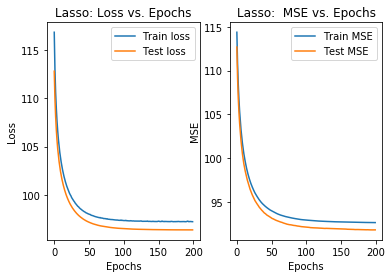

In [11]:
# plot loss and accuracies graphs

regr.plot_graph(train_losses, test_losses, train_mse_arr, test_mse_arr)

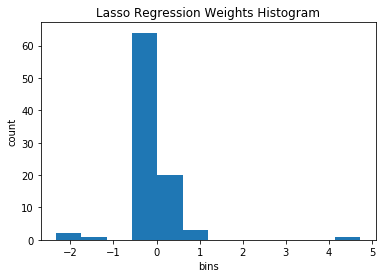

In [12]:
# plot the weights
regr.plot_weights()

In [13]:
test_preds

array([[1996],
       [1995],
       [2002],
       ...,
       [1997],
       [2002],
       [2000]])